# Part 1: Intensity Transformations and Filtering

This notebook demonstrates intensity transformations and filtering on three sample images from the Dresden Dataset.

## Group Members
1. Asfar Hossain Sitab (2022-3-60-275)
2. Parmita Hossain Simia (2022-3-60-253)
3. Kamran Hasan (2022-2-60-077)
4. Nusrat Jahan Oishi (2022-2-60-033)

## Data Loading

Load necessary libraries and select three sample images.

Loaded image 1: 23_image18.png
Loaded image 2: colon_19_32_aug_elastic_shift_1.png
Loaded image 3: inferior_mesenteric_artery_28_15_aug_rot-30_rot30_1.png


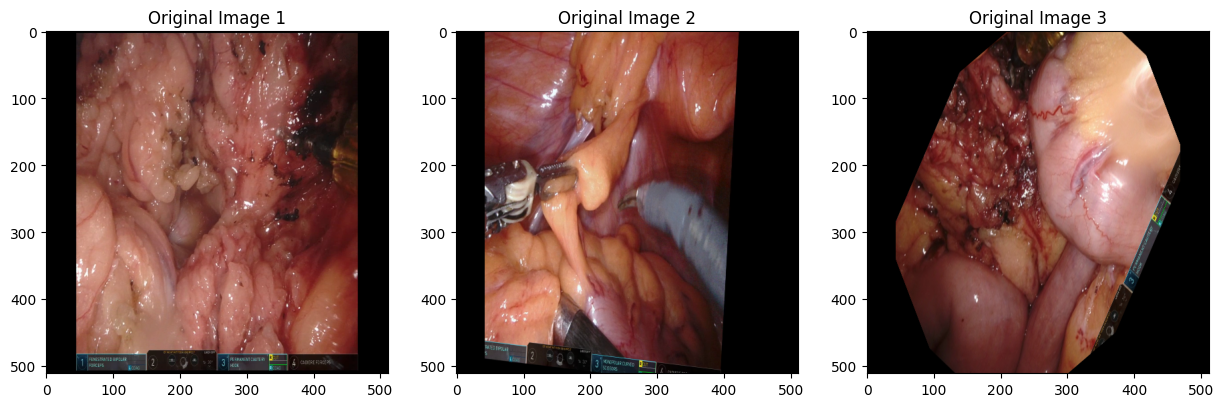

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
import os

# Assuming dataset is mounted at /kaggle/input/dresden-dataset
dataset_path = '/kaggle/input/the-dresden-surgical-anatomy-dataset/Dresden Dataset'
train_images_path = os.path.join(dataset_path, 'images/train')

# Select three sample images
sample_images = []
for i, img_file in enumerate(os.listdir(train_images_path)[:3]):
    img_path = os.path.join(train_images_path, img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    sample_images.append(img)
    print(f"Loaded image {i+1}: {img_file}")

# Display original images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, img in enumerate(sample_images):
    axes[i].imshow(img)
    axes[i].set_title(f'Original Image {i+1}')
plt.show()

## Intensity Transformations

Apply four different intensity transformations: Log transformation, Gamma correction, Contrast stretching, and CLAHE.

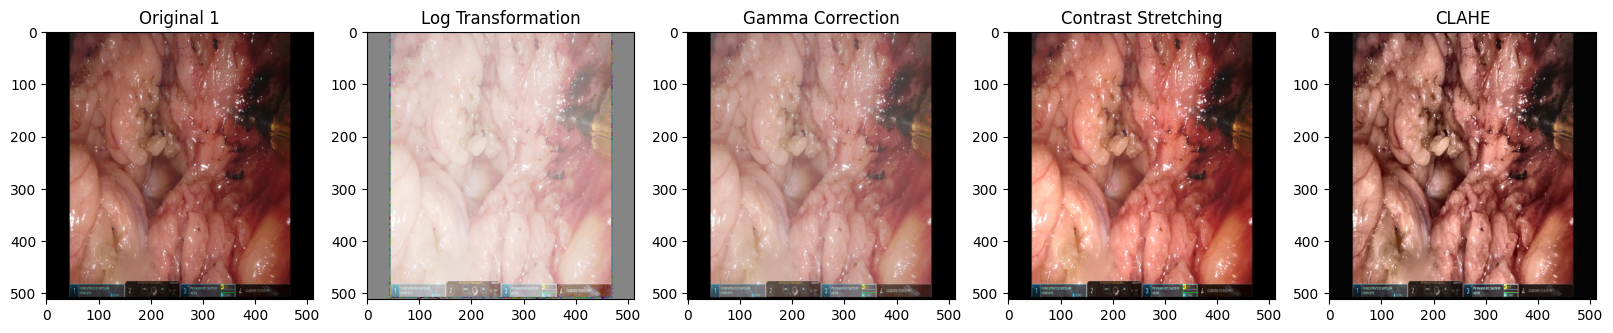

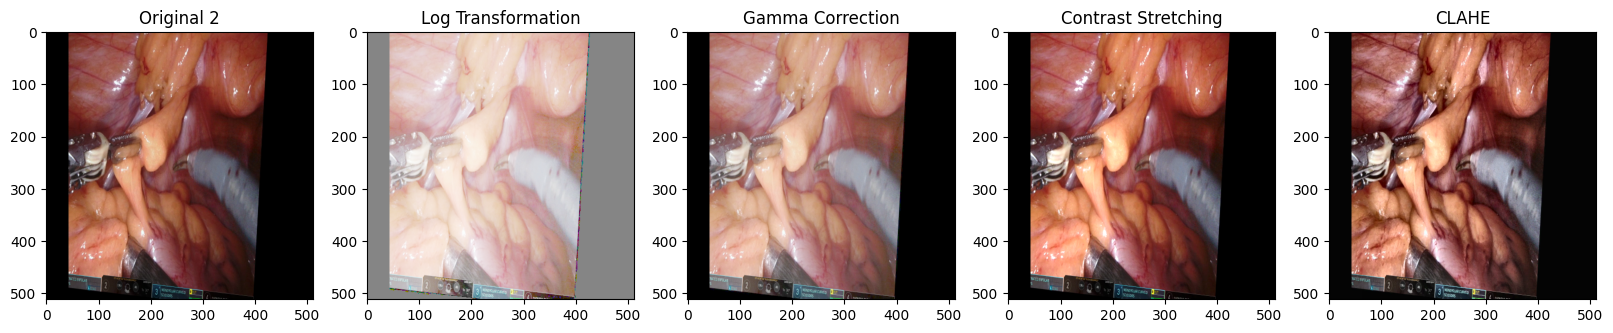

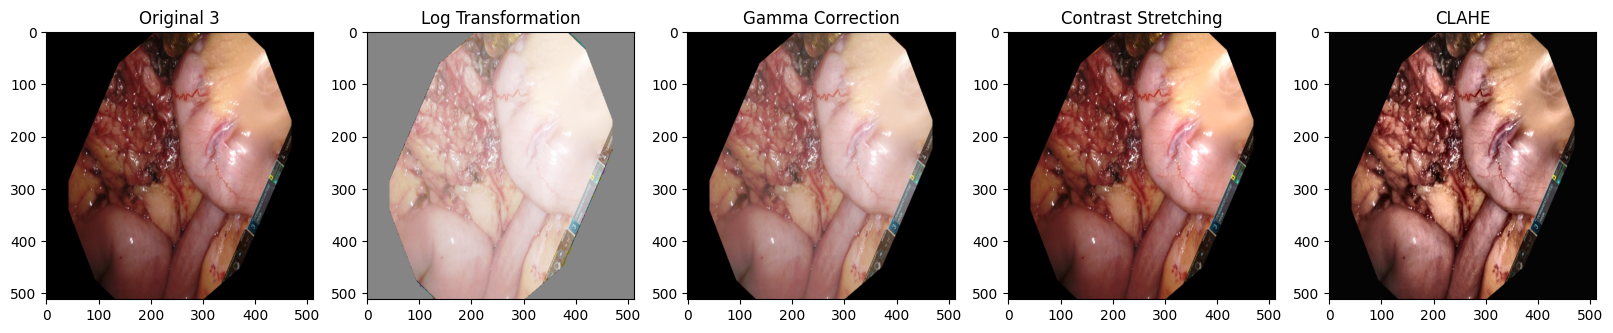

In [2]:
# Function to apply transformations
def apply_transformations(img):
    # Log transformation
    # Add a small constant to avoid log(0) and handle potential inf values
    img_float = img.astype(np.float64) + 1e-6  # Add small constant to avoid log(0)
    c = 255 / np.log(1 + np.max(img_float))
    log_img = c * (np.log(img_float))
    log_img = np.array(log_img, dtype=np.uint8)


    # Gamma correction
    gamma = 0.5
    gamma_img = np.array(255 * (img / 255) ** gamma, dtype='uint8')

    # Contrast stretching
    p2, p98 = np.percentile(img, (2, 98))
    contrast_img = exposure.rescale_intensity(img, in_range=(p2, p98))

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    if len(img.shape) == 3:
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        lab[:, :, 0] = clahe.apply(lab[:, :, 0])
        clahe_img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    else:
        clahe_img = clahe.apply(img)

    return log_img, gamma_img, contrast_img, clahe_img

# Apply to each sample image
transformed_images = []
for img in sample_images:
    transformed_images.append(apply_transformations(img))

# Display results
transform_names = ['Log Transformation', 'Gamma Correction', 'Contrast Stretching', 'CLAHE']
for i, (orig, trans) in enumerate(zip(sample_images, transformed_images)):
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    axes[0].imshow(orig)
    axes[0].set_title(f'Original {i+1}')
    for j, t_img in enumerate(trans):
        axes[j+1].imshow(t_img)
        axes[j+1].set_title(transform_names[j])
    plt.show()

### Explanations

- **Log Transformation**: Enhances darker regions, useful for images with wide dynamic range.
- **Gamma Correction**: Adjusts brightness; gamma < 1 brightens the image.
- **Contrast Stretching**: Improves contrast by stretching the intensity range.
- **CLAHE**: Adaptive histogram equalization, reduces noise while enhancing local contrast.

## Filtering Operations

Apply three different filters: Mean filter, Gaussian blur, and Median filter.

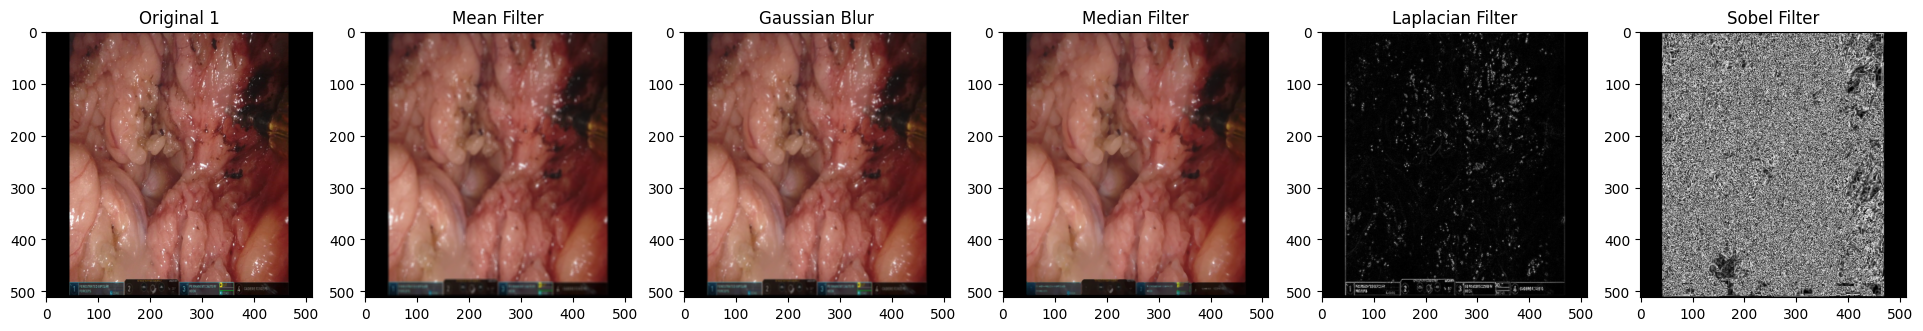

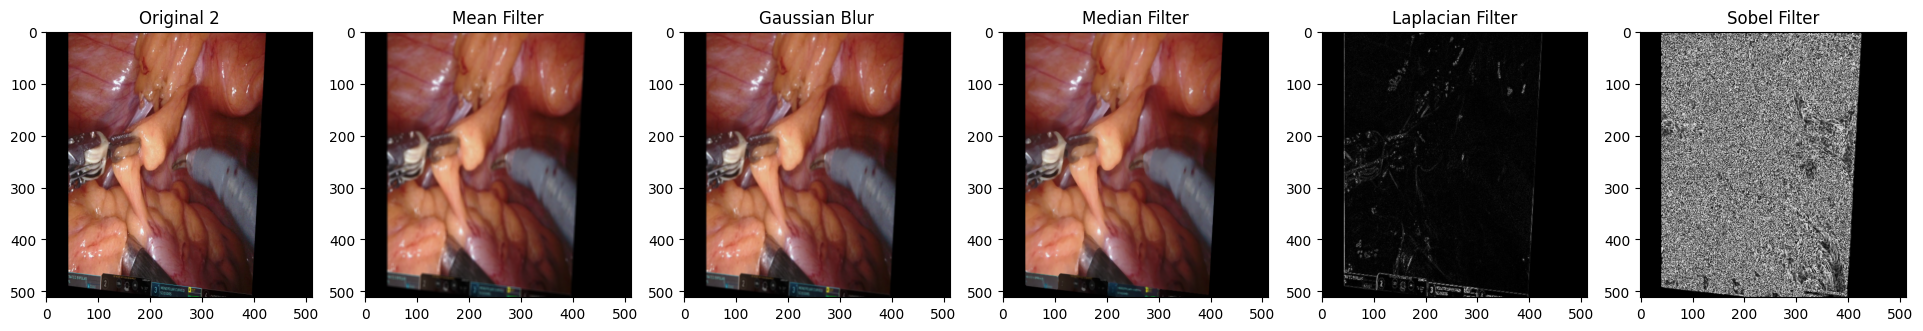

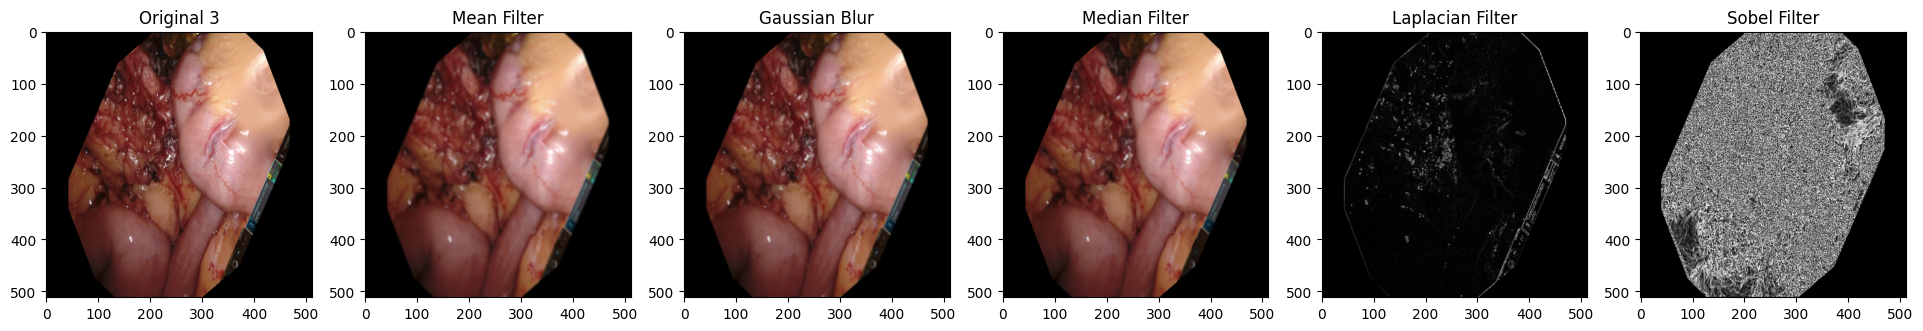

In [3]:
# Function to apply filters
def apply_filters(img):
    # Mean filter
    mean_img = cv2.blur(img, (5, 5))

    # Gaussian blur
    gauss_img = cv2.GaussianBlur(img, (5, 5), 0)

    # Median filter
    median_img = cv2.medianBlur(img, 5)

    # Laplacian filter (edge enhancement)
    # Convert to grayscale before applying Laplacian
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    laplacian_img = cv2.Laplacian(gray_img, cv2.CV_64F)
    laplacian_img = np.uint8(np.absolute(laplacian_img)) # Convert back to uint8

    # Sobel filter (edge enhancement)
    # Convert to grayscale before applying Sobel
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=5)
    sobel_img = np.uint8(np.sqrt(sobelx**2 + sobely**2)) # Combine x and y gradients

    return mean_img, gauss_img, median_img, laplacian_img, sobel_img

# Apply to each sample image
filtered_images = []
for img in sample_images:
    filtered_images.append(apply_filters(img))

# Display results
filter_names = ['Mean Filter', 'Gaussian Blur', 'Median Filter', 'Laplacian Filter', 'Sobel Filter']
for i, (orig, filt) in enumerate(zip(sample_images, filtered_images)):
    fig, axes = plt.subplots(1, 6, figsize=(24, 4)) # Increased subplot count for new filters
    axes[0].imshow(orig)
    axes[0].set_title(f'Original {i+1}')
    for j, f_img in enumerate(filt):
        # For Laplacian and Sobel, use 'gray' colormap as they are grayscale outputs
        cmap = 'gray' if filter_names[j] in ['Laplacian Filter', 'Sobel Filter'] else None
        axes[j+1].imshow(f_img, cmap=cmap)
        axes[j+1].set_title(filter_names[j])
    plt.show()

### Explanations

- **Mean Filter**: Blurs the image by averaging neighboring pixels, reducing noise but can lose edges.
- **Gaussian Blur**: Smooths the image with a Gaussian kernel, preserving edges better than mean filter.
- **Median Filter**: Effective for salt-and-pepper noise, preserves edges while removing noise.